In [1]:
def theta_ft(h,ft_intercept,gamma):
    """
       input h (meters) and the coefficients for the linear
       profile for the free troposphere theta (ft_intercept (K)  and slope gamma (K/m))
       return the free tropospher theta at height h
    """
    theta_top = ft_intercept + h*gamma
    return theta_top

#
# helper function to turn a dictionary into a named tuple
#
from collections import namedtuple
def make_tuple(tupname,in_dict):
    the_tup = namedtuple(tupname, in_dict.keys())
    the_tup = the_tup(**in_dict)
    return the_tup

In [2]:
%matplotlib inline
import numpy as np
import scipy.integrate as integrate
from matplotlib import pyplot as plt
import pandas as pd
import thermlib
from importlib import reload
reload(thermlib)
from thermlib import thermfuncs as tf



def dmixed_vars(the_vars,tstep,coeffs):
    """
      the_vars[0]= thetabar
      the_vars[1] = h
      the_vars[2] = qv
      
      surface flux from drag law with subsidence and diagnosed deltheta
    """
    #print('the_vars: ',the_vars,D,U)
    deltheta = theta_ft(the_vars[1],coeffs.ft_intercept,coeffs.ft_gamma) - the_vars[0]
    F0 = coeffs.U*coeffs.Cd*(coeffs.sst - the_vars[0])  #surface heat flux
    Fqv0 = coeffs.U*coeffs.Cd*(coeffs.qsfc - the_vars[2])  #surface vapor flux
    Fint = -coeffs.k*F0  #entrainment heat flux
    went = -Fint/deltheta  #entrainment velocity (positive upward)
    Fqvent = -went*( coeffs.ft_qv - the_vars[2])
    wsubs = -coeffs.D*the_vars[1]
    rho=1.
    cp=1004.
    derivs=np.empty_like(the_vars)
    derivs[0]=(F0 - Fint)/(the_vars[1]*rho) - 30./1004./the_vars[1]
    derivs[1] = went + wsubs
    derivs[2] = (Fqv0 - Fqvent)/the_vars[1]
    return derivs

In [3]:
reload(thermlib)
from thermlib import thermfuncs as tf
dtout=10.  #minutes
end_time=8*24.   #hours
del_time=dtout*60. #seconds
end_time=end_time*3600. #seconds
sst=297
D=5.e-6  #s-1
U=7  #m/s
psfc=100. #kPa
qsfc=tf.qs_tp(sst,psfc)
ft_intercept = 292 #K
ft_gamma = 6.e-3  #K/m
ft_qv = 2.e-3
k=0.6  #entrainment efficiency
Cd = 1.e-3  #drag coefficient
tspan = np.arange(0.,end_time,del_time)
vars_init=[285.,400.,8.e-3]  #theta (K), height (m) qv (kg/kg) to start
the_tup=dict(D=D,U=U,sst=sst,ft_intercept=ft_intercept,ft_gamma=ft_gamma,
             qsfc=qsfc,ft_qv=ft_qv,k=k,Cd=Cd)
the_tup=make_tuple('coeffs',the_tup)
output=integrate.odeint(dmixed_vars, vars_init, tspan,(the_tup,))
result=pd.DataFrame.from_records(output,columns=['theta','h','qv'])
result['time']=tspan/3600./24.  #days
result['deltheta'] = theta_ft(result['h'].values,ft_intercept,ft_gamma) - result['theta']

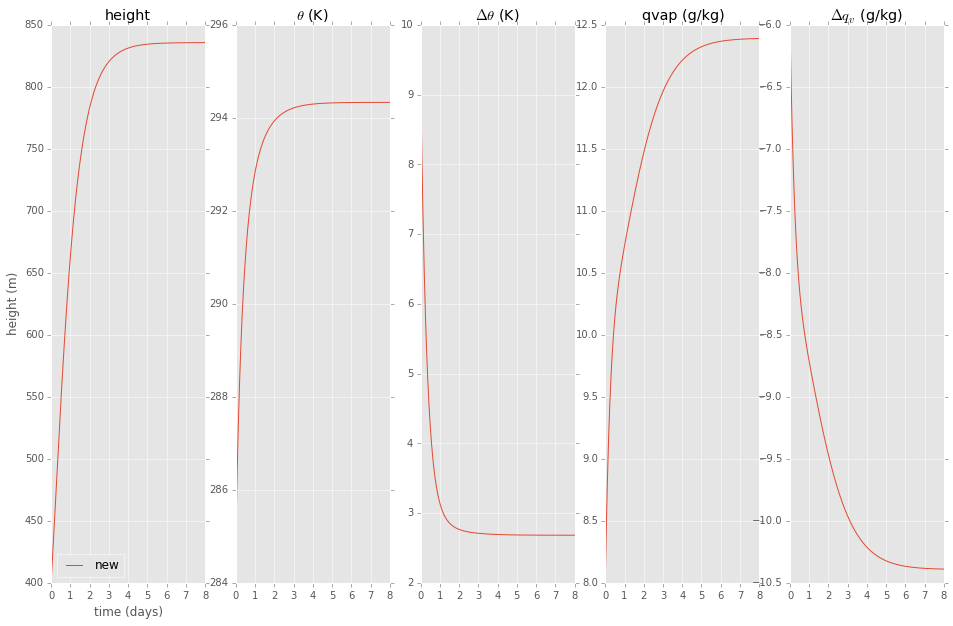

In [4]:
%matplotlib inline
plt.close('all')
plt.style.use('ggplot')
fig,ax = plt.subplots(1,5,figsize=(16,10))
ax[0].plot(result['time'],result['h'],label='new')
ax[0].set(ylabel='height (m)',xlabel='time (days)',title='height')
ax[0].legend(loc='best')
ax[1].plot(result['time'],result['theta'],label='new')
out=ax[1].set(title=r'$\theta$ (K)')
out=ax[2].plot(result['time'],result['deltheta'],label='new')
out=ax[2].set(title=r'$\Delta \theta$ (K)')
out=ax[3].plot(result['time'],result['qv']*1.e3,label='new')
out=ax[3].set(title='qvap (g/kg)')
result['delqv'] = ft_qv - result['qv']
out=ax[4].plot(result['time'],result['delqv']*1.e3)
out=ax[4].set(title=r'$\Delta q_v$ (g/kg)')

In [5]:
reload(thermlib)
from thermlib import thermfuncs as tf
def calc_lcl(row,psfc):
    """
      find the lcl (in m) for a row in the dataframe
    """
    Tdew = tf.tmr(row['qv'],psfc)
    LCL = tf.LCL(Tdew,row['theta'],psfc)  #kPa
    #
    # rough approximation:  10 kPa = 1 km
    #
    delp=psfc - LCL
    lcl_h = delp*100.
    return lcl_h


def calc_sfc_theta_flux(row,coeffs):
    F0 = coeffs.U*coeffs.Cd*(coeffs.sst - row['theta'])  #surface heat flux
    return F0

def calc_sfc_qvap_flux(row,coeffs):
    Fqv0 = coeffs.U*coeffs.Cd*(coeffs.qsfc[0] - row['qv'])
    return Fqv0

def calc_entflux_theta(row,coeffs):
    flux_ent = -coeffs.k*row['T_flux_0']
    return flux_ent

def calc_went(row,coeffs):
    went = -row['entflux_theta']/row['deltheta']
    return went
    
def calc_entflux_qv(row,coeffs):
    flux_ent =  -row['went']*( coeffs.ft_qv - row['qv'])
    return flux_ent


result['LCL']=result.apply(calc_lcl,axis=1,args=(psfc,))
result['q_flux_0']=result.apply(calc_sfc_qvap_flux,axis=1,args=(the_tup,))
result['T_flux_0']=result.apply(calc_sfc_theta_flux,axis=1,args=(the_tup,))  
result['thick'] = result['h'] - result['LCL']
result['entflux_theta']=result.apply(calc_entflux_theta,axis=1,args=(the_tup,))
result['went'] = result.apply(calc_went,axis=1,args=(the_tup,))
result['entflux_qv']=result.apply(calc_entflux_qv,axis=1,args=(the_tup,))

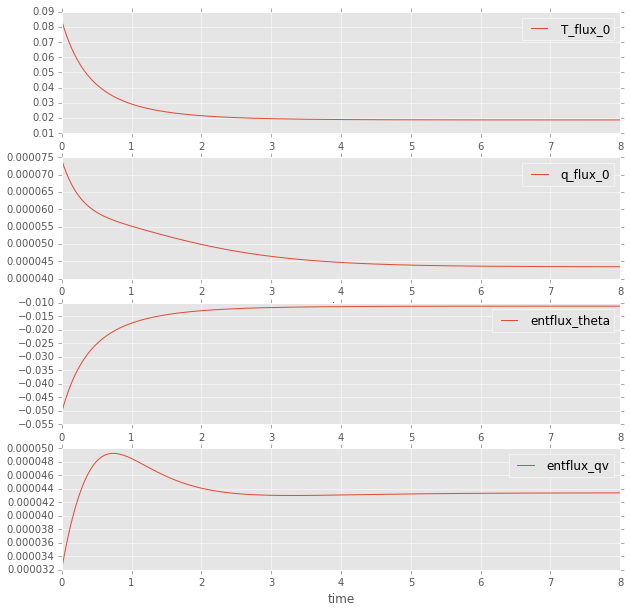

In [6]:
fig,ax=plt.subplots(4,1,figsize=(10,10))
result.plot('time','T_flux_0',ax=ax[0])
result.plot('time','q_flux_0',ax=ax[1])
result.plot('time','entflux_theta',ax=ax[2])
out=result.plot('time','entflux_qv',ax=ax[3])

In [32]:
# calculate mixed-layer flux profiles, ignoring radiative flux divergence (i.e. assume z1 = h)

def calc_qvslope(row):
    qv_slope =  (-row['q_flux_0'])/row['h']
    return qv_slope

def calc_thetaslope(row):
    theta_slope =  (-row['T_flux_0'])/row['h']
    return theta_slope


# calculate coefficients for buoyancy flux

def calc_d(theta, qv):
    epsilon_i = 0.61
    Ad = 1 + epsilon_i*qv
    Bd = epsilon_i*theta
    return Ad,Bd


def calc_w(theta, qv, z):
    epsilon_i = 0.61
    epsilon = 1/(1 + epsilon_i)
    P0 = 1000 # hPa
    T = theta/(P0/(P0 - 0.1*z))**(0.286)
    Lv = 2.485e6
    Rv = 461.5
    cp = 1004
    dqdt = (qv*Lv)/(Rv*T**2)
    Aw = (1 + qv/epsilon - qv + theta/epsilon*dqdt)/(1+Lv/cp*dqdt)
    Bw = Aw*(Lv/cp) - theta
    
    return Aw,Bw


# calculate mixed layer profile slopes
result['qv_slope']=result.apply(calc_qvslope,axis=1)
result['theta_slope']=result.apply(calc_thetaslope,axis=1)

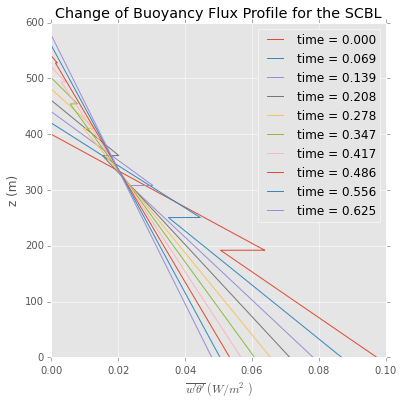

In [81]:
theFig, theAx = plt.subplots(1,1,figsize=(6,6))

for t in range(0, 100, 10):
    z_levels = np.arange(0,result["h"][t],0.1) # get z levels for plotting profiles
    buoyant_flux = np.zeros([1, len(z_levels)])
    
    for z_ind in range(len(z_levels)):
        
        qv_flux = result["qv_slope"][t]*z_levels[z_ind] + result["q_flux_0"][t]
        theta_flux = result["theta_slope"][t]*z_levels[z_ind] + result["T_flux_0"][t]
        
        if z_levels[z_ind] < result["LCL"][t]: # take LCL as bottom of the cloudy layer
            A,B = calc_d(result["theta"][t],result["qv"][t]) # deal with subcloud layer
        else:
            A,B = calc_w(result["theta"][t],result["qv"][t],z_levels[z_ind]) # deal with cloudy layer

        buoyant_flux[0,z_ind] = (A*theta_flux + B*qv_flux)
    theAx.plot(buoyant_flux[0,:], z_levels, label = "time = {:.3f}".format(result.time[t]))
theAx.legend(loc="best")
theAx.set(title="Change of Buoyancy Flux Profile for the SCBL", xlabel=r"$\overline{w'\theta'}\ (W/m^2)$", ylabel="z (m)")

In [84]:
result

,theta,h,qv,time,deltheta,delqv,LCL,q_flux_0,T_flux_0,thick,entflux_theta,went,entflux_qv,qv_flux,qv_slope,theta_slope
0,285.000000,400.000000,0.008000,0.000000,9.400000,-0.006000,192.075118,0.000074,0.084000,207.924882,-0.050400,0.005362,0.000032,-1.050069e-07,-1.854324e-07,-0.000210
1,285.155085,402.017731,0.008062,0.006944,9.257022,-0.006062,197.841685,0.000074,0.082914,204.176047,-0.049749,0.005374,0.000033,-1.023791e-07,-1.834185e-07,-0.000206
2,285.306834,404.036864,0.008123,0.013889,9.117387,-0.006123,203.647000,0.000073,0.081852,200.389864,-0.049111,0.005387,0.000033,-9.982185e-08,-1.814510e-07,-0.000203
3,285.455328,406.057363,0.008182,0.020833,8.981016,-0.006182,209.482706,0.000073,0.080813,196.574657,-0.048488,0.005399,0.000033,-9.733311e-08,-1.795286e-07,-0.000199
4,285.600664,408.079190,0.008240,0.027778,8.847811,-0.006240,215.341469,0.000072,0.079795,192.737721,-0.047877,0.005411,0.000034,-9.491075e-08,-1.776499e-07,-0.000196
5,285.742922,410.102306,0.008296,0.034722,8.717692,-0.006296,221.216352,0.000072,0.078800,188.885954,-0.047280,0.005423,0.000034,-9.255288e-08,-1.758136e-07,-0.000192
6,285.882177,412.126668,0.008351,0.041667,8.590583,-0.006351,227.101014,0.000072,0.077825,185.025655,-0.046695,0.005436,0.000035,-9.025768e-08,-1.740185e-07,-0.000189
7,286.018510,414.152234,0.008404,0.048611,8.466404,-0.006404,232.989699,0.000071,0.076870,181.162534,-0.046122,0.005448,0.000035,-8.802338e-08,-1.722635e-07,-0.000186
8,286.151992,416.178954,0.008456,0.055556,8.345081,-0.006456,238.877126,0.000071,0.075936,177.301828,-0.045562,0.005460,0.000035,-8.584824e-08,-1.705473e-07,-0.000182
9,286.282700,418.206781,0.008507,0.062500,8.226541,-0.006507,244.758505,0.000071,0.075021,173.448276,-0.045013,0.005472,0.000036,-8.373059e-08,-1.688689e-07,-0.000179


 (Bretherton 15.19, assume $h \approx z_i$) $$w_*^3 = 2.5\int_{0}^{h}{B(z)dz}$$ 

 $$w_*^3 = 2.5\frac{g}{\theta_0}[\int_{0}^{z_c}{(A_d\overline {w'\theta_l'} + B_d\overline {w'q_v'})\ dz} + \int_{z_c}^{h}(A_w\overline {w'\theta_l'} + B_w\overline {w'q_v'})\ dz\  ] $$
 
 $$w_*^3 = 2.5\frac{g}{\theta_0}[z_c(A_d\overline {w'\theta_l'} + B_d\overline {w'q_v'} - A_w\overline {w'\theta_l'} - B_w\overline {w'q_v'}) + h(A_w\overline {w'\theta_l'} + B_w\overline {w'q_v'})\ ]$$
 
 $$w_* = (2.5\frac{g}{\theta_0}[(z_c(A_d - A_w) + hA_w)\overline{w'\theta_l'} + (z_c(B_d - B_w) + hB_w)\overline{w'q_v'}\ ])^{1/3}$$
 
 

 (Bretherton 15.19, assume $h \approx z_i$) $$w_*^3 = 2.5\int_{0}^{h}{B(z)dz}$$ 

 $$w_*^3 = 2.5\frac{g}{\theta_0}[\int_{0}^{z_c}{(A_d\overline {w'\theta_l'} + B_d\overline {w'q_v'})\ dz} + \int_{z_c}^{h}(A_w\overline {w'\theta_l'} + B_w\overline {w'q_v'})\ dz\  ] $$
 
 Take $\overline{w'\theta_l'} = mz + \overline{w'\theta_l'}_0$,  $\overline{w'q_v'} = nz + \overline{w'q_v'}_0$, where $m = slope_{\theta_{flux}}$, $n = slope_{q_{flux}}$ and integrate :
 
 $w_* = (2.5\frac{g}{\theta_0}[(A_d(\frac{m} {2} z_c^2 + \overline{w'\theta_l'}_0z_c) + B_d(\frac {n} {2} z_c^2 + \overline{w'q_v'}_0z_c) + A_w(\frac{m} {2} h^2 + \overline{w'\theta_l'}_0h - \frac{m} {2} z_c^2 + \overline{w'\theta_l'}_0z_c) + B_w(\frac {n} {2} h^2 + \overline{w'q_v'}_0h - \frac {n} {2} z_c^2 + \overline{w'q_v'}_0z_c)])^{1/3}$

In [96]:
def calc_wstar(row):
    g = 9.81
    Ad_term = row["Ad"]*(row["theta_slope"]/2*row["LCL"]**2 + row["T_flux_0"]*row["LCL"])
    Bd_term = row["Bd"]*(row["qv_slope"]/2*row["LCL"]**2 + row["q_flux_0"]*row["LCL"])
    Aw_term = row["Aw"]*(row["theta_slope"]/2*row["h"]**2 + row["T_flux_0"]*row["h"] - row["theta_slope"]/2*row["LCL"]**2 + row["T_flux_0"]*row["LCL"])
    Bw_term = row["Bw"]*(row["qv_slope"]/2*row["h"]**2 + row["q_flux_0"]*row["h"] - row["qv_slope"]/2*row["LCL"]**2 + row["q_flux_0"]*row["LCL"])
    
    wstar = 2.5*g/row["theta"]*(Ad_term + Bd_term + Aw_term + Bw_term)
    
    return wstar
    
def average_calc_Ad(row):
    epsilon_i = 0.61
    Ad = 1 + epsilon_i*row["qv"]
    return Ad

def average_calc_Bd(row):
    epsilon_i = 0.61
    Bd = epsilon_i*row["theta"]
    return Bd

def average_calc_Aw(row):
    epsilon_i = 0.61
    epsilon = 1/(1 + epsilon_i)
    P0 = 1000 # hPa
    T = row["theta"]/(P0/(P0 - 0.1*0.5*(row["h"]+row["LCL"])))**(0.286)
    Lv = 2.485e6
    Rv = 461.5
    cp = 1004.
    dqdt = (row["qv"]*Lv)/(Rv*T**2)
    Aw = (1 + row["qv"]/epsilon - row["qv"] + row["theta"]/epsilon*dqdt)/(1+Lv/cp*dqdt)

    return Aw

def average_calc_Bw(row):
    Lv = 2.485e6
    cp = 1004.
    Bw = row["Aw"]*(Lv/cp) - row["theta"]
    
    return Bw

result['Ad']=result.apply(average_calc_Ad,axis=1)
result['Bd']=result.apply(average_calc_Bd,axis=1)
result['Aw']=result.apply(average_calc_Aw,axis=1)
result['Bw']=result.apply(average_calc_Bw,axis=1)
result["wstar"]=result.apply(calc_wstar,axis=1)

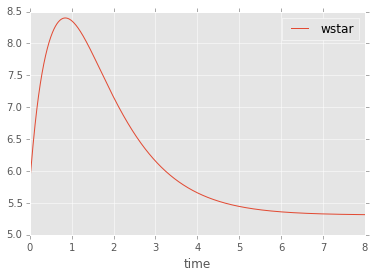

In [101]:
result.plot('time','wstar')